In [1]:

import os
import rasterio.plot
from rasterio.plot import show
import tensorflow as tf
import random
import cv2 as cv 
import rasterio
from rasterio.transform import from_origin
from rasterio import features
import pandas as pd
import math 
import geopandas as gpd
import shapely
from shapely.geometry import Point, Polygon
from mining_pages_utils.tensorflow_utils import run_vesselprofile_segmentation, readNoextensionImage, build_detectfn
from tensorflow import keras
import glob
from typing import List
from abc import ABCMeta, abstractmethod
import requests
from typing import Tuple
from mining_pages_utils.request_utils import addModifiedEntry

import datetime


from mining_pages_utils.request_utils import getListOfDBs
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import label_map_util
from object_detection.utils import ops as utils_ops
from pathlib import Path
from descartes import PolygonPatch
from typing import Tuple
from tqdm import tqdm
import numpy as np
from PIL import Image
import matplotlib as mpl

mpl.use('Agg')
%matplotlib notebook
import matplotlib.pyplot as plt
from PIL import Image, ImageColor
from IPython.display import display
import datetime
import numpy as np
from shutil import copy
import requests
import rasterio.mask
import json

In [ ]:
descriptor = 'resnet'

In [ ]:
def draw_mask_on_image_array(image, mask, color='red', alpha=0.7):
  """Draws mask on an image.

  Args:
    image: uint8 numpy array with shape (img_height, img_height, 3)
    mask: a float numpy array of shape (img_height, img_height) with
      values between 0 and 1
    color: color to draw the keypoints with. Default is red.
    alpha: transparency value between 0 and 1. (default: 0.7)

  Raises:
    ValueError: On incorrect data type for image or masks.
  """
  if image.dtype != np.uint8:
    raise ValueError('`image` not of type np.uint8')
  if mask.dtype != np.float32:
    raise ValueError('`mask` not of type np.float32')
  if np.any(np.logical_or(mask > 1.0, mask < 0.0)):
    raise ValueError('`mask` elements should be in [0, 1]')
  rgb = ImageColor.getrgb(color)
  pil_image = Image.fromarray(image)

  solid_color = np.expand_dims(
      np.ones_like(mask), axis=2) * np.reshape(list(rgb), [1, 1, 3])
  pil_solid_color = Image.fromarray(np.uint8(solid_color)).convert('RGBA')
  pil_mask = Image.fromarray(np.uint8(255.0*alpha*mask)).convert('L')
  pil_image = Image.composite(pil_solid_color, pil_image, pil_mask)
  np.copyto(image, np.array(pil_image.convert('RGB'))) 

In [4]:
def mask_to_polygons_layer(mask):
    all_polygons = []
    for shape, value in features.shapes(mask.astype(np.int16), mask=(mask >0), transform=rasterio.Affine(1.0, 0, 0, 0, 1.0, 0)):
        #return shapely.geometry.shape(shape)
        all_polygons.append(shapely.geometry.shape(shape))
        #print('What does the mask_10:layer give us?', shape, value)
        


    all_polygons = shapely.geometry.MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = shapely.geometry.MultiPolygon([all_polygons])
    patch = PolygonPatch(all_polygons.buffer(0))
    fig, ax = plt.subplots()
    ax.add_patch(patch)
    ax.set_xlim(0, 1300)
    ax.set_ylim(0, 777)
    plt.show()
    return all_polygons

In [47]:
def polygons_to_mask(geodf, image_np):
    if 'geometry' in geodf.columns:
    
        #print('Polygonsto Mask Geometry is valid!')
        out_image = rasterio.features.rasterize(geodf['geometry'], out_shape=(image_np.shape[0],image_np.shape[1]))
        return out_image

In [7]:
def close_holes(series, smallerthanarea):
    """
    Close polygon holes by limitation to the exterior ring.
    Args:
        poly: Input shapely Polygon
    Example:
        df.geometry.apply(lambda p: close_holes(p))
    
    """
    exterior=Polygon(series['geometry'].exterior.coords)
    if series['geometry'].geom_type == 'Polygon':
        print('I am still a Polygon')
        if series['geometry'].interiors:
            largeinteriors = []
            for interior in series['geometry'].interiors:
                interior=Polygon(interior.coords)
                print('This is the interior areasize: ', interior.area)
                print('This is the smallerthanarea: ', smallerthanarea)
                if interior.area > smallerthanarea:
                    print('This interior will make a difference')
                    exterior = exterior.difference(interior)
    series['geometry']=exterior
    return series
        
   
 



In [8]:
def getarea(series):
    series['area']=series['geometry'].area
    print('This is the Area: ', series['area'])
    return series

In [9]:
def bufferpoly (series, buffer):
    series['geometry']=series['geometry'].buffer(buffer)
    return series

In [10]:
def multi2singlepolygon (multipolygons):
    listpolygons = []
    if multipolygons.geom_type == 'MultiPolygon':
        print('I am Multipolygon')
        # extract polygons out of multipolygon
        for polygon in multipolygons.geoms:
            if polygon.type == 'Polygon':
                exterior_coords = polygon.exterior.coords[:]
                interior_coords = []
                for interior in polygon.interiors:
                    interior_coords += interior.coords[:]
                print('This is the interiors of multi2single:', interior_coords)
            if polygon.geom_type == 'Polygon':
                print(vars(polygon))
                #print('But now I am not anymore or?', type(polygon))
                listpolygons.append(polygon)

    if multipolygons.geom_type == 'GeometryCollection':
        print('I am GeometryCollection')
        # extract polygons out of multipolygon
        for polygon in multipolygons.geoms:
            print('I am an elemnt of GeomCollection: ', polygon.geom_type)
            if polygon.geom_type == 'Polygon':
                print('But now I am not anymore or?', type(polygon))
                listpolygons.append(polygon)
    elif multipolygons.geom_type == 'Polygon':
        listpolygons.append(multipolygons)
    else:
        print('What kind of Geomerty are you? Answer: ',multipolygons.geom_type)
    


    return listpolygons

In [11]:
def multi2singlepolygon_df (gdf):
    newgdf = gpd.GeoDataFrame()
    for index, row in gdf.iterrows():

        if row['geometry'].geom_type == 'MultiPolygon':
            print('I am Multipolygon')
            # extract polygons out of multipolygon
            for polygon in row['geometry'].geoms:
                if polygon.type == 'Polygon':
                    exterior_coords = polygon.exterior.coords[:]
                    interior_coords = []
                    for interior in polygon.interiors:
                        interior_coords += interior.coords[:]
                    print('This is the interiors of multi2single:', interior_coords)
                if polygon.geom_type == 'Polygon':
                    print(vars(polygon))
                    #print('But now I am not anymore or?', type(polygon))
                    singlepolyrow = row
                    singlepolyrow['geometry']=polygon
                    newgdf = newgdf.append(singlepolyrow)

        if row['geometry'].geom_type == 'GeometryCollection':
            print('I am GeometryCollection')
            # extract polygons out of multipolygon
            for polygon in row['geometry'].geoms:
                print('I am an elemnt of GeomCollection: ', polygon.geom_type)
                if polygon.geom_type == 'Polygon':
                    print('But now I am not anymore or?', type(polygon))
                    singlepolyrow = row
                    singlepolyrow['geometry']=polygon
                    newgdf = newgdf.append(singlepolyrow)
        elif row['geometry'].geom_type == 'Polygon':
            singlepolyrow = row
            singlepolyrow['geometry']=row['geometry']
            newgdf = newgdf.append(singlepolyrow)
        else:
            print('What kind of Geomerty are you? Answer: ',row['geometry'].geom_type)
    


    return newgdf

In [12]:
def simplify(series, d, cf):
    print('Simplify tolerance distance and cf: ', d, cf)
    series['geometry'] = series['geometry'].buffer(-d).buffer(d*cf).intersection(series['geometry']).simplify(d)
   
    return series
    

In [13]:
def filterintersects(tobefilteredgdf, referencegdf, largerthanthis):
    filteredgdf = gpd.GeoDataFrame()
    for index, targetrow in tobefilteredgdf.iterrows():
        for index, referencerow in referencegdf.iterrows():
            if targetrow['geometry'].intersects(referencerow['geometry']) or targetrow['geometry'].area > largerthanthis :
                filteredgdf = filteredgdf.append(targetrow)
    return filteredgdf
    

In [50]:
def process_files(vessel):
    print(vessel)
    image_np = readNoextensionImage(vessel)
    print(type(image_np))
    input_tensor = tf.convert_to_tensor(image_np)
    input_tensor = input_tensor[tf.newaxis, ...]
    detections = miningfiguresdetectfn(input_tensor)
    image_np_with_detections = image_np.copy()
    empty_with_detections = np.zeros((image_np.shape[0], image_np.shape[1], image_np.shape[2])).astype(np.uint8)
    
    #num_detections = int(output_dict.pop('num_detections'))
    #print(num_detections)
    # The following processing is only for single image
    detection_boxes = tf.squeeze(detections['detection_boxes'], [0])
    detection_masks = tf.squeeze(detections['detection_masks'], [0])
    #print(detection_boxes)
    
    # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
    real_num_detection = tf.cast(detections['num_detections'][0], tf.int32)
    detection_boxes = tf.slice(detection_boxes, [0, 0],
                            [real_num_detection, -1])
    #print('detection_boxes', detection_boxes)
    detection_masks = tf.slice(detection_masks, [0, 0, 0],
                            [real_num_detection, -1, -1])
    #print('detection_masks', detection_masks)
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
        detection_masks, detection_boxes, image_np.shape[0], image_np.shape[1])
    detection_masks_reframed = tf.cast(
        tf.greater(detection_masks_reframed, 0.5), tf.uint8)
    # Follow the convention by adding back the batch dimension
    detections['detection_masks'] = tf.expand_dims(detection_masks_reframed, 0)

    detections['num_detections'] = int(detections['num_detections'][0])
    detections['detection_classes'] = detections['detection_classes'][0].numpy(
    ).astype(np.uint8)
    detections['detection_boxes'] = detections['detection_boxes'][0].numpy()
    detections['detection_scores'] = detections['detection_scores'][0].numpy()
    detections['detection_masks'] = detections['detection_masks'][0].numpy()

    #print(detections['detection_scores'])
    #print('image-size: ',image_np.shape)
    #print('mask-size: ',detections['detection_masks'].shape)


 



    vis_util.visualize_boxes_and_labels_on_image_array(
        empty_with_detections,
        detections['detection_boxes'],
        detections['detection_classes'],
        detections['detection_scores'],
        category_index,
        instance_masks=detections['detection_masks'],
        use_normalized_coordinates=True,
        max_boxes_to_draw=3,
        min_score_thresh=.6,
        mask_alpha=1,
        skip_boxes=True,
        skip_scores= True,
        skip_labels=True)


    
    mask = empty_with_detections[:,:,:1]
    

    if not cv.countNonZero(mask) == 0 :
        detectedmask = mask.astype(np.uint8)
        print('any smalle than 255')
        mask = mask.astype(np.uint8)
        
        kernelwidth = int(image_np.shape[0] * image_np.shape[1] / 4000)
        kernelheight = int(image_np.shape[0] * image_np.shape[1] / 2000)
        kernel = np.ones((kernelheight,kernelwidth),np.uint8)
        
        print('firstkernel',kernel.shape)
        mask = cv.dilate(mask,kernel,iterations = 1)
        kernelwidth = int(math.sqrt(image_np.shape[0] * image_np.shape[1]) / 50)
        kernelheight = int(math.sqrt(image_np.shape[0] * image_np.shape[1]) / 50)
        kernel = np.ones((kernelwidth,kernelheight),np.uint8)
        print('This is the Kernel to erode the detectedmask: ', kernel.shape)
        detectedmask = cv.erode(detectedmask,kernel,iterations = 1)


        mask[mask > 0] = cv.GC_PR_FGD
        mask[mask == 0] = cv.GC_BGD
        fgModel = np.zeros((1, 65), dtype="float")
        bgModel = np.zeros((1, 65), dtype="float")
        (mask, bgModel, fgModel) = cv.grabCut(image_np, mask, None, bgModel,fgModel, 10, mode=cv.GC_INIT_WITH_MASK)
        values = (
            ("Definite Background", cv.GC_BGD),
            ("Probable Background", cv.GC_PR_BGD),
            ("Definite Foreground", cv.GC_FGD),
            ("Probable Foreground", cv.GC_PR_FGD),
        )
        
        valuemask = (mask == cv.GC_PR_FGD).astype("uint8") * 255
        detectedmask = detectedmask.astype("uint8") * 255
        valuemask = cv.addWeighted(detectedmask, 0.5, valuemask, 0.5, 0.0)

        plt.imshow(detectedmask)
        plt.show()
        print(detectedmask.shape)
        plt.imshow(valuemask)
        plt.show()
        print(valuemask.shape)
        kernelwidth = int(image_np.shape[0] * image_np.shape[1] / 80000)
        kernelheight = int(image_np.shape[0] * image_np.shape[1] / 80000)
        kernel = np.ones((kernelwidth,kernelheight),np.uint8)
        #valuemask = cv.dilate(valuemask,kernel,iterations = 1)
        multipolygons = mask_to_polygons_layer(valuemask)
        #print('This is the length of mask_to_polygons resullt (grabcut): ', multipolygons)
        detectedmask_polys = mask_to_polygons_layer(detectedmask)

        
        print('Here comes grabcut multi2single:')
        listpolygons = multi2singlepolygon(multipolygons)
        print('This is the length of multi2singlepolygon resullt (grabcut): ', len(listpolygons))
        print('Here comes detected multi2single:')
        detected_listpolygons = multi2singlepolygon(detectedmask_polys)

        
        detectedpolygons = [{'geometry':polygon, 'method':'detected'} for polygon in detected_listpolygons]
        print(detectedpolygons)
        detecteddf = pd.DataFrame(detectedpolygons)
        detectedgdf = gpd.GeoDataFrame(detecteddf, geometry='geometry')        

        #listpolygons = list(multipolygons.geoms)
        polygons = [{'geometry':polygon, 'method':'grabcut'} for polygon in listpolygons]
        
        df = pd.DataFrame(polygons)
        gdf = gpd.GeoDataFrame(df, geometry='geometry')
        gdf.plot()
        print('This is before close_holes:')
        plt.show()
        gdf = gdf.apply(close_holes, smallerthanarea=int(image_np.shape[0] * image_np.shape[1] / 1000), axis=1)
        #buffer = -image_np.shape[0] * image_np.shape[1] / 160000
        #gdf = gdf.apply(bufferpoly, buffer=buffer, axis=1)
        gdf.plot()
        print('This is after close_holes:')
        plt.show()        
        gdf=gdf.apply(getarea, axis=1)
        gdfmax= gdf.nlargest(5, 'area', keep='first')

        #print ('tolerance=', str(image_np.shape[0] * image_np.shape[1] / 160000))
        #gdfmax = gdfmax.apply(simplify, d=1.5, cf=1.6, axis=1)
        buffer = -int(math.sqrt(image_np.shape[0] * image_np.shape[1]) / 200)
        print('This is the Buffer ',buffer)
        gdfmax = gdfmax.apply(bufferpoly, buffer=buffer, axis=1)
        buffer = int(math.sqrt(image_np.shape[0] * image_np.shape[1]) / 200)
        gdfmax = gdfmax.apply(bufferpoly, buffer=buffer, axis=1)
        gdfmax = multi2singlepolygon_df(gdfmax)
        gdfmax=gdfmax.apply(getarea, axis=1)
        print('Only larger than this survives:', int(image_np.shape[0] * image_np.shape[1] / 300))
        gdfmax=gdfmax[gdfmax['area'] > int(image_np.shape[0] * image_np.shape[1] / 300)]
        gdfmax = gdfmax.apply(close_holes, smallerthanarea=int(image_np.shape[0] * image_np.shape[1] / 1000), axis=1)
        gdfmax=gdfmax.apply(getarea, axis=1)
        print(gdfmax)
        if not gdfmax.empty and 'geometry' in gdfmax.columns:
            gdfmax = filterintersects(gdfmax, detectedgdf, largerthanthis=max(gdfmax['area'])/30)
       


            #gpd.GeoDataFrame(gdf, geometry='geometry')
            

            transform = from_origin(0, 0, 1, 1)

            image_raster = rasterio.open(vessel, 'r', driver='PNG',transform=transform)
            #gdfmax = gpd.GeoDataFrame(gdfmax, geometry='geometry')

        
            #rasterio.plot.show((image_raster, 1))
            out_image = polygons_to_mask(gdfmax, empty_with_detections)
            show(out_image)
            plt.show()
            original_img = Image.fromarray(image_np)
            segimage = out_image
            #max(multipolygon, key=lambda a: a.area)
            fig, ax = plt.subplots(figsize=(15,15))
            rasterio.plot.show(image_raster, ax=ax)
            gdfmax.plot(ax=ax, facecolor='none', edgecolor='red')
            detectedgdf.plot(ax=ax, facecolor='none', edgecolor='green')
            #show(ax)
            
            plt.show()#
            return original_img, segimage



        #print(type(polygons))
        
        #show(out_image)
        #plt.show()

        #kernelwidth = int(image_np.shape[0] / 120)
        #kernelheight = int(image_np.shape[1] / 120)
        #kernel = np.ones((kernelwidth,kernelheight),np.uint8)
        #mask = cv.erode(mask,kernel,iterations = 1)

        #plt.figure()
        #plt.imshow(valuemask)
        #plt.show()
	
    #ret,thresh1 = cv.threshold(gray,127,255,cv.THRESH_BINARY)
    #(mask, bgModel, fgModel) = cv.grabCut(img, mask, rect, bgdModel, fgdModel, iterCount[, mode])  

    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'],
        detections['detection_classes'],
        detections['detection_scores'],
        category_index,
        instance_masks=detections['detection_masks'],
        use_normalized_coordinates=True,
        max_boxes_to_draw=2,
        min_score_thresh=.5)

 
    print(type(detections['detection_masks']))
    print(detections['detection_masks'].shape)
    #pil_mask = Image.fromarray(np.uint8(255.0*0.4*(detections['detection_masks'] > 0))).convert('L')
    #pil_mask = pil_image.convert('RGB')
    #np.copyto(image, np.array(pil_image.convert('RGB')))
    #segmented_img = Image.fromarray(pil_mask)

    

        

In [31]:
def addToVOCfolder (original_img, segmented_img):
    #vocfolder, subsettextfile, segmentclassfolder, segmentobjectfolder
    #pil_mask = Image.fromarray(np.uint8(255.0*0.4*(segmented_img > 0))).convert('L')
    #pil_mask = pil_image.convert('RGB')
    #np.copyto(image, np.array(pil_image.convert('RGB')))
    print('This is the segmented image:' , segmented_img.shape, type(segmented_img))
    segmented_img = Image.fromarray(segmented_img)
    segmented_img.save(os.path.join(segmentclassfolder, os.path.basename(vessel) + '.png'), format='png')
    original_img.save(outputpath + taskname + '_originals/'+ os.path.basename(vessel) + '.png') 
    
    with subsettextfile.open('a+') as f:
        f.write(os.path.basename(vessel) + "\n")
    
    

In [16]:
def selectimages(amount ):

    vessel_image_list = [ os.path.join(data_path, i) for i in random.sample(os.listdir(data_path), amount)]
    #print(vessel_image_list)
    return vessel_image_list

In [3]:
seg_model = "E:/Traindata/mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8_profilesegmentv11/saved_model"
PATH_TO_LABELS = "E:/Traindata/mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8_profilesegmentv10/labelmap.pbtxt"
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
db_url = 'http://localhost:3000'
auth = ('', 'blub')
alldbs = getListOfDBs(db_url, auth)
selectlist = ['tallzira_ed']
list = [item for item in alldbs if item.endswith('_ed') or item.endswith('_edv2') ]
list = [item for item in list if not item.endswith('ock_ed')]
print(list)
imagestore = 'E:/mining_shapes/imagestore/'
miningfiguresdetectfn = build_detectfn(seg_model)



['althiburos_ed', 'bonifay2004_ed', 'hayes1972_edv2', 'lattara6_edv2', 'sabratha_ed', 'sidikhrebish_ed', 'simitthus_ed', 'tallzira_ed', 'urukcatalogs_ed']
Loading model...Done! Took 29.648000478744507 seconds


E:/mining_shapes/imagestore/althiburos_ed/2a1a4542-d231-49d1-9841-53ae028e6cb8
<class 'numpy.ndarray'>
any smalle than 255
firstkernel (59, 29)
This is the Kernel to erode the detectedmask:  (6, 6)


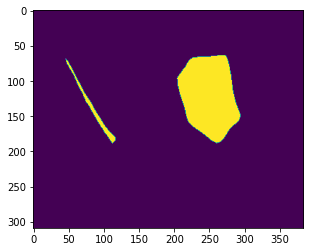

(309, 384)


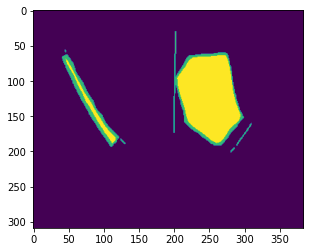

(309, 384)


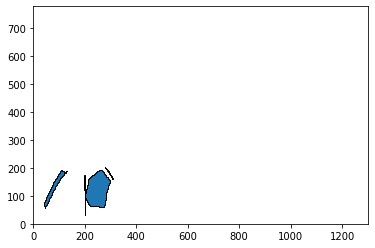

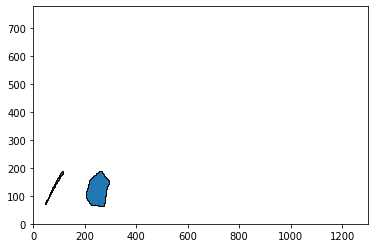

Here comes grabcut multi2single:
I am Multipolygon
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2085879614160, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x000001E5AE3CEFA0>, '_exterior': <weakref at 0x000001E56B569A40; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2085879613520, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x000001E5AE3CEFA0>, '_exterior': <weakref at 0x000001E56B5695E0; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2085879615440, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x000001E5AE3CEFA0>, '_exterior': <weakref at 0x000001E56B56C0E0; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2085879614080, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object a

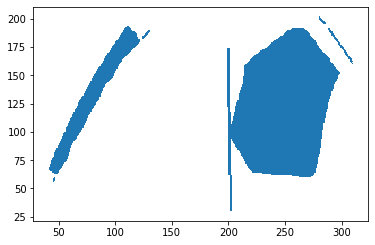

I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
This is after close_holes:


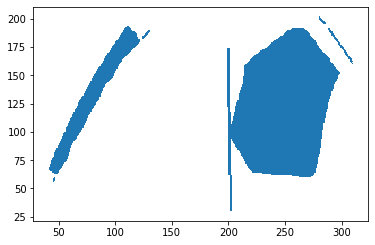

This is the Area:  70.0
This is the Area:  1.0
This is the Area:  9269.0
This is the Area:  17.0
This is the Area:  20.0
This is the Area:  1920.0
This is the Area:  6.0
This is the Buffer  -1
This is the Area:  8986.729237004472
This is the Area:  1886.1169104360642
This is the Area:  0.0
This is the Area:  0.0
This is the Area:  0.0
Only larger than this survives: 395
I am still a Polygon
I am still a Polygon
This is the Area:  8986.729237004472
This is the Area:  1886.1169104360642
                                            geometry   method         area
2  POLYGON ((200.000 107.000, 200.005 107.100, 20...  grabcut  8986.729237
5  POLYGON ((41.999 65.999, 41.951 66.001, 41.850...  grabcut  1886.116910


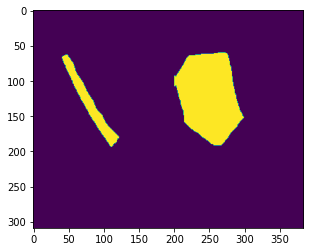

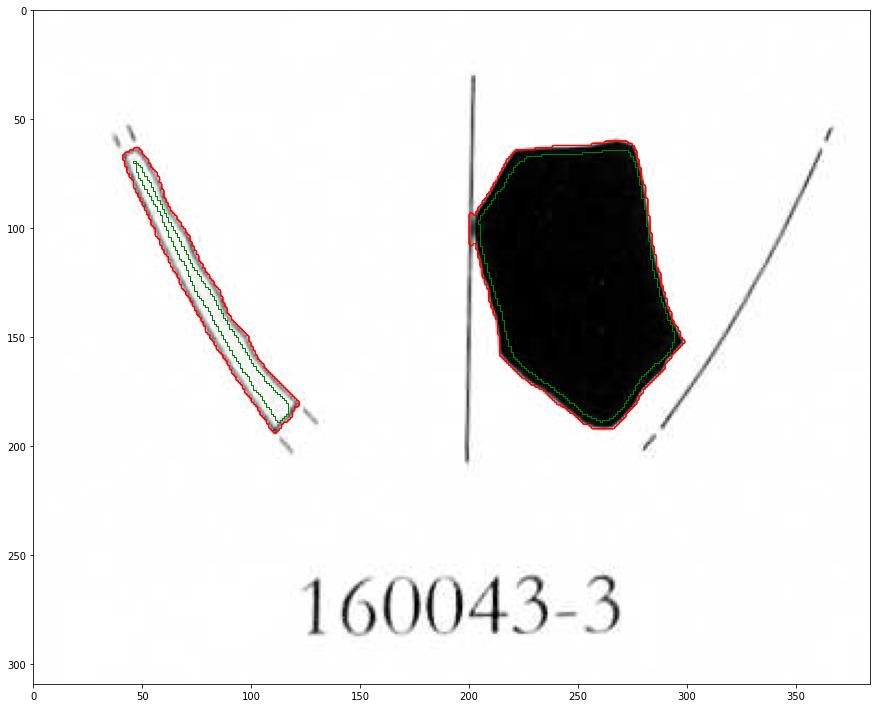

This is the segmented image: (309, 384) <class 'numpy.ndarray'>


NameError: name 'segmentclassfolder' is not defined

In [51]:
%matplotlib inline
selectlist = ['lattara6_edv2', 'sidikhrebish_ed','simitthus_ed','althiburos_ed']
selectlist50 = ['althiburos_ed','lattara6_edv2', 'sidikhrebish_ed','simitthus_ed','bonifay2004_ed', 'hayes1972_edv2', 'sabratha_ed', 'tallzira_ed']
outputpath = "E:/mining_shapes/segmented_profiles/"
vessel_image_list = []
taskname = 'ImproveMaskTrain2'
labelmappath =  Path("E:/Traindata/Trainingdata_fromCVAT/profile_segmentation/tfrecordimpoved/label_map.txt")


for db_name in list:
    data_path = imagestore + db_name +'/'
    vessel_image_list_db = selectimages(3)
    #
    vessel_image_list = vessel_image_list + vessel_image_list_db

vocfolder, subsettextfile, segmentclassfolder, segmentobjectfolder = createVOCfolder(outputpath, taskname,labelmappath)
#print(vocfolder)
for vessel in vessel_image_list:
    #print(vessel)
    original_img, segmented_img = process_files(vessel)
    addToVOCfolder(original_img, segmented_img)
    print("Compute feature vectors")
    drawingID = os.path.basename(vessel)
    db_name = os.path.dirname(vessel)
    resnetfeatures = compute_resnet_featurevector(segmented_img)
    print(resnetfeatures)
    #fourierfeatures = compute_fourier_featurevector(segmented_img)